# 5. Handcrafted Model 2.0: 

### I. Team-Members:
- Felix Gaber, 20221385@novaims.unl.pt
- Felix Gayer, 20220320@novaims.unl.pt
- David Halder, 20220632@novaims.unl.pt
- Lukas Stark, 20220626@novaims.unl.pt
- Rita Soares, 20220616@novaims.unl.pt


### II. Link to the Dataset:
https://drive.google.com/drive/folders/1D8Hd49L0OLlSz2oCuuctfCKDcR8HK_c4?usp=share_link


###III. Summary of the notebook:
#### III a. Model development process

In the following Notebook a sequential model is defined, based on a version of the ``LeNet-5`` & ``AlexNet``. Contrary to the main notebook **Handcrafted_Model_Lenet** this optional notebook simplifies step by step the architecture of the AlexNet and implements different regularization methods to get the main problem of overfitting under control.

With regard to the comments on the individual loss and accuracy curves, this notebook is rather brief. Many of the steps are repetitive and thus there are no major new insights after every Model.

During the creation of the handcrafted model, the recommended steps outlined by *Goodfellow, Bengio, and Courville* (2018, p. 416 pp.) are adhered to:

- **Determine your goals — what error metric to use, and your target value for this error metric. These goals and error metrics should be driven by the problem that the application is intended to solve**
 - For this example, a high ``accuracy`` is the most reasonable choise since the tires should only be exchanged when they are indeed showing sign of wear. Changing them prior, would be  economically and ecologically inefficient. However, not changing them in time also bears risk of accidents or supply chain breakdowns. Thus, the main performance metric of this project is ``Accuracy``

- **Establish a working end-to-end pipeline as soon as possible, including the  estimation of the appropriate performance metrics.**
 - Taking into consideration the different trials and experiments, the goal for the final test performance is set to **80%**

- **Instrument the system well to determine bottlenecks in performance. Diagnose which components are performing worse than expected and whether poor performance is due to overfitting, underfitting, or a defect in the data or software.**
 - The analysis of the developed models is also explained in detail during the various experiments conducted

- **Repeatedly make incremental changes such as gathering new data, adjusting hyperparameters, or changing algorithms, based on specific findings from your instrumentation.**
 - The steps taken to build and tune the models are justified along their development.

The notebook is structured according to this procedure.

# References
1. Chen, ZhiYu; Abidi, Besma R.; Page, David L.; Abidi, Mongi A. (2006): Gray-level grouping (GLG): an automatic method for optimized image contrast enhancement--Part I: the basic method. In IEEE transactions on image processing : a publication of the IEEE Signal Processing Society 15 (8), pp. 2290–2302. DOI: 10.1109/tip.2006.875204.
2. Chollet, François (2018): Deep learning with Python. Shelter Island, NY: Manning.


In [ ]:
#@title Google Drive Connection
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/DeepLearningProject/03 Project'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1_93ad1t8CGrSTc3bgngEEjuCVXLB6eHY/03 Project


---

# 5.1 Imports

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import data
from keras import Sequential, layers, initializers, regularizers, optimizers, metrics
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.callbacks import EarlyStopping, ModelCheckpoint

try: 
  from skimage import exposure
except:
  !pip install skimage
  from skimage import exposure

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 24.8 MB/s eta 0:00:00


---

# 5.2 Load & Preprocess Data via *flow_from_directory*


### 5.2.1 Set image_dataset_from_directory flow_from_directory Parameters

During the course of this notebook, volatile validation-loss & validation-accuracy may occur. We tried to get this under control by increasing the batch size. However, this did not work and so we are back to a batch size of 32.

In [ ]:
image_size = (224, 224)
color_mode = 'rgb'
batch_size = 32
validation_size = 0.3
class_mode = 'binary'
label_mode = 'binary'
classes = ['normal', 'cracked']
shuffle = True
seed = 420

train_folder = 'Data/Tire Textures/training_data'
test_folder  = 'Data/Tire Textures/testing_data'

## 5.2.2 Load & Preprocess Data

Training and test data are loaded using the ImageDataGenerator and flow_from_directory functions. The training data is split into a 70:30 ratio for training and validation, respectively. We will already create two different train and validation splits. One normal one without any augmentation and modifications called ds_train & ds_val as well as ds_test of course. The other one ds_train_aug, ds_val_aug & ds_test_aug will be slightly augmented using the ImageDataGenerator with a custom preprocessing function called "hist_eq" which is actually a function from the scikit-image library called "exposure.equalize_hist". This function performs histogram equalization on the input image, which redistributes the pixel intensities in the image to improve contrast and enhance details. Besides that the brightness of ds_train_aug is also randomly adjusted within a range of 0.5 to 1.5 as well as horizontal and vertical flip set to true. With a for loop we will stretch the ~500 samples to a training data size sligthly above 3000.

**Disclaimer:** Since the custom *hist_eq* function acts like a filter to the images and is applied to each image in the training set we see this as a preprocessing step. Therefore we also apply this filter to the validation (ds_val_aug) and test data (ds_test_aug). If we only apply histogram equalization to the validation and test data without also applying it to the training data, we may introduce a distribution shift between the training and validation/test sets. This shift can lead to poor generalization performance of your model, as it may not be able to accurately predict the labels of the validation and test data, even if it performs well on the training data.

Here an example how the distributions are shifting after applying histogram equalization.

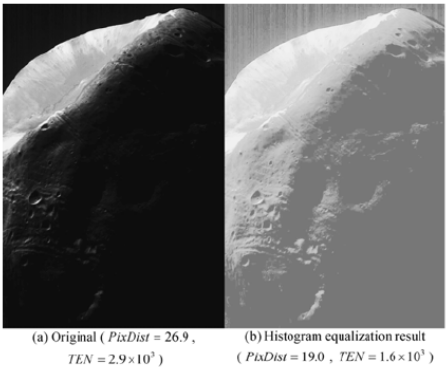

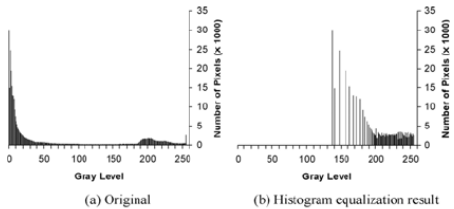

*Image Source & Paper:* (See Chen et al, 2006)[1]

In [ ]:
# Function to apply histogram equalization
def hist_eq(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Generator to preprocess & augment training data
train_gen = ImageDataGenerator(
    preprocessing_function=hist_eq,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=validation_size
    )

# Generator to preprocess validation & test data
val_test_gen = ImageDataGenerator(
    preprocessing_function=hist_eq,
    validation_split=validation_size
    )

# Basic generator to only load the data
generator_basic = ImageDataGenerator(
    validation_split=validation_size
    )

print('Training Data (Basic)\n---------------------------------------')
ds_train = generator_basic.flow_from_directory(
    directory=train_folder,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    subset="training",
    class_mode=class_mode,
    classes=classes,
    shuffle=shuffle,
    seed=seed
    )

print('\n\nValidation Data (Basic)\n---------------------------------------')
ds_val = generator_basic.flow_from_directory(
    directory=train_folder,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    subset="validation",
    class_mode=class_mode,
    classes=classes,
    shuffle=shuffle,
    seed=seed
    )

print('\n\nTest Data (Basic)\n---------------------------------------')
ds_test = generator_basic.flow_from_directory(
    directory=test_folder,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    classes=classes,
    seed=seed
    )

##################################################################################################

print('\n\nTraining Data (Histogram Equalization)\n---------------------------------------')
generator = train_gen.flow_from_directory(
    directory=train_folder,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    subset="training",
    class_mode=class_mode,
    classes=classes,
    shuffle=shuffle,
    seed=seed
    )

# generate new augmented images and corresponding labels
augmented_images = []
augmented_labels = []
for i in range(100):
    batch = generator.next()
    augmented_images.append(batch[0])
    augmented_labels.append(batch[1])

# concatenate the augmented images and labels into arrays
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

# create a batch dataset from the augmented images and labels
ds_train_aug = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels)).batch(batch_size)

num_samples = tf.data.experimental.cardinality(ds_train_aug).numpy()
print("\nTraining Dataset Size after augmentation:", num_samples * batch_size)

print('\n\nValidation Data (Histogram Equalization)\n---------------------------------------')
ds_val_aug = val_test_gen.flow_from_directory(
    directory=train_folder,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    subset="validation",
    class_mode=class_mode,
    classes=classes,
    shuffle=shuffle,
    seed=seed
    )

print('\n\nTest Data (Histogram Equalization)\n---------------------------------------')
ds_test_aug = val_test_gen.flow_from_directory(
    directory=test_folder,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    classes=classes,
    seed=seed
    )

##################################################################################################
# Combine train and validation data to fit the final model on all of the data
print('\n\nTrain Data Final (Histogram Equalization)\n---------------------------------------')
generator_final = train_gen.flow_from_directory(
    directory=train_folder,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    classes=classes,
    shuffle=shuffle,
    seed=seed
    )

# generate new augmented images and corresponding labels
augmented_images = []
augmented_labels = []
for i in range(85):
    batch = generator_final.next()
    augmented_images.append(batch[0])
    augmented_labels.append(batch[1])

# concatenate the augmented images and labels into arrays
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

# create a batch dataset from the augmented images and labels
ds_combined = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels)).batch(batch_size)

num_samples = tf.data.experimental.cardinality(ds_combined).numpy()
print("\nTraining Dataset Final Size after augmentation:", num_samples * batch_size)

Training Data (Basic)
---------------------------------------
Found 493 images belonging to 2 classes.


Validation Data (Basic)
---------------------------------------
Found 210 images belonging to 2 classes.


Test Data (Basic)
---------------------------------------
Found 335 images belonging to 2 classes.


Training Data (Histogram Equalization)
---------------------------------------
Found 493 images belonging to 2 classes.


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)



Training Dataset Size after augmentation: 3104


Validation Data (Histogram Equalization)
---------------------------------------
Found 210 images belonging to 2 classes.


Test Data (Histogram Equalization)
---------------------------------------
Found 335 images belonging to 2 classes.


Train Data Final (Histogram Equalization)
---------------------------------------
Found 703 images belonging to 2 classes.

Training Dataset Final Size after augmentation: 2400


# 5.3 Visualize Augmented Data

### 5.3.1 *Function:* Plot Images

In [ ]:
def check_images(dataset):
  if isinstance(dataset, data.Dataset):
    # get the first batch from the dataset
    for images, labels in dataset.take(1):
      # plot the images
      fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
      for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i])
        ax.axis("off")
        ax.set_title(f"Class: {labels[i]}")
      plt.show()
  elif isinstance(dataset, DirectoryIterator):
    # retrieve a batch of images from the DirectoryIterator
    images, labels = next(dataset)
    # plot the images
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
    for i, ax in enumerate(axes.flatten()):
      ax.imshow(images[i], cmap='gray')
      ax.axis("off")
      ax.set_title(f"Class: {labels[i]}")
    plt.show()
  else:
    class_names = {0: 'normal', 1: 'cracked'}
    # get the first batch of images and labels
    for images, labels in ds_train_aug.take(1):
        # plot the images using subplot
        fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(images[i].numpy())
            ax.axis("off")
            ax.set_title(class_names[int(labels[i])])
        plt.show()


### 5.3.3 Check ds_train_aug

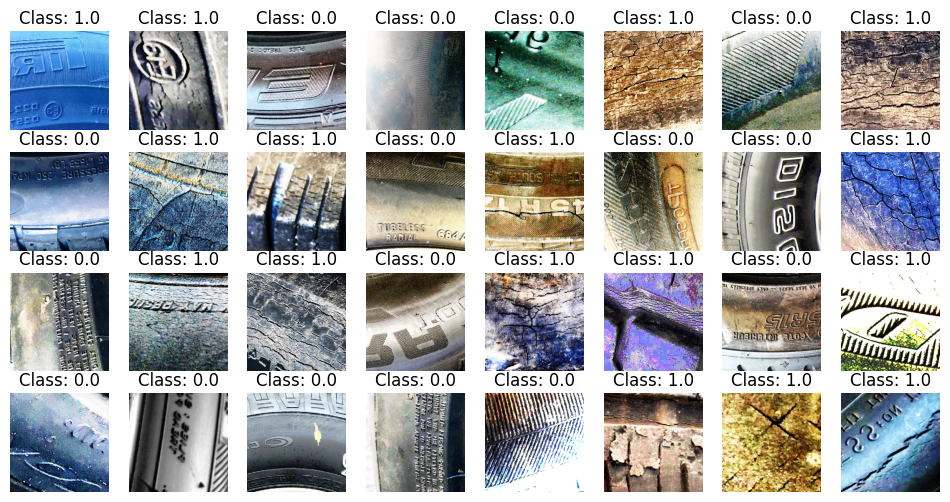

In [ ]:
check_images(ds_train_aug)

### 5.3.4 Check ds_val_aug

In [ ]:
check_images(ds_val_aug)

### 5.3.5 Check ds_test_aug

In [ ]:
check_images(ds_test_aug)

---
# 5.4 Iterative Model Development

#### 5.4.1 Set Input Shape

In [ ]:
# Defines input shape from image size and color mode
input_shape = (*image_size, 1 if color_mode=='grayscale' else 3)

#### 5.4.2 *Function:* Plot Accuracy & Loss Curves

In [ ]:
model_name = 'missing'

def plot_curves(model_fit=None, model_name=model_name):
  # if the model just not got fit we will load the saved dataframe from the last run
  # this dataframe contains the following columns - [epoch, accuracy, val_accuracy, accuracy_difference]
  if model_fit == None:
    df_hist = pd.read_csv(f'/content/drive/MyDrive/DeepLearningProject/03 Project/Handcrafted_AlexNet/{model_name}.csv')
  # if the model just got fitted we will save the output (dataframe) as a csv
  # this enables us to save the last executed run
  else:
    # Create DataFrame object
    df_hist = pd.DataFrame.from_dict(model_fit.history)
    df_hist['Epoch'] = np.arange(1, len(df_hist) + 1, 1)
    df_hist['accuracy_difference'] = round(df_hist.accuracy - df_hist.val_accuracy, 2)
    # save results dataframe as csv - NOT NEEDED FOR TEACHERS
    # df_hist.to_csv(f'/content/drive/MyDrive/DeepLearningProject/03 Project/Handcrafted_AlexNet/{model_name}.csv', index=False)


  # after creating/loading the dataframe the following lines plot the loss & accuracy curves
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

  # Plot accuracy and validation accuracy
  axs[0].plot(df_hist['Epoch'], df_hist['accuracy'], label='Training Accuracy')
  axs[0].plot(df_hist['Epoch'], df_hist['val_accuracy'], label='Validation Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].legend(loc='upper left')

  # Plot loss and validation loss
  axs[1].plot(df_hist['Epoch'], df_hist['loss'], label='Training Loss')
  axs[1].plot(df_hist['Epoch'], df_hist['val_loss'], label='Validation Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].legend(loc='lower left')

  # Display final 5 results
  display(df_hist[['Epoch', 'accuracy', 'val_accuracy', 'accuracy_difference']].tail(5))
  print('\n','\n')

  # Show the plot
  plt.show()

## 5.4.3 LeNet-5 & AlexNet
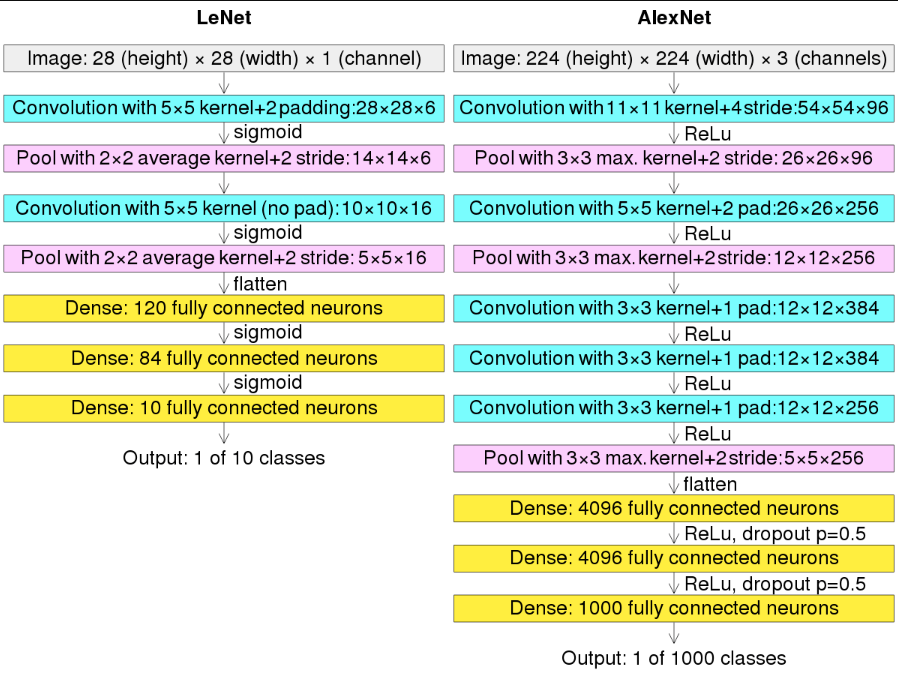

---

### 5.4.3.1 LeNet-5

We have chosen the LeNet-5 architecture as our baseline. This architecture was first introduced in 1998 by Yann LeCun and was one of the early successful convolutional neural networks. The simple architecture provides a good starting point for obtaining initial results. It has 7 layers consisting of 2 convolutional layers, 2 pooling layers, and 3 dense layers, with a manageable number of neurons and filters that allow for faster processing. For a more detailed overview see chapter 3.4.2.1 Baseline in the 03_Handcrafted_Model Notebook. By using this architecture, we can get an idea of what to expect from the data, and assess whether additional complexity is required. To fit our binary classification problem, we made a slight modification to the output layer by having only one unit as well as using the sigmoid activation function.

We will first train the models with the original data, therefore no data augmentation.

In [ ]:
model_name = 'LeNet'

In [ ]:
lenet = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=6, kernel_size=(5, 5), activation='sigmoid'),
    layers.AveragePooling2D(pool_size=(2, 2)),
    # 2. conv layer
    layers.Conv2D(filters=16, kernel_size=(5, 5), activation='sigmoid'),
    layers.AveragePooling2D(pool_size=(2, 2)),
    # Flatten layer
    layers.Flatten(),
    # Fully connected layers
    layers.Dense(units=120, activation='sigmoid'),
    layers.Dense(units=84, activation='sigmoid'),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

lenet.summary()

In [ ]:
# Compile Model
lenet.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_lenet = lenet.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_lenet, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
4      5  0.535497      0.533333                  0.0
5      6  0.535497      0.533333                  0.0
6      7  0.535497      0.533333                  0.0
7      8  0.535497      0.533333                  0.0
8      9  0.535497      0.533333                  0.0

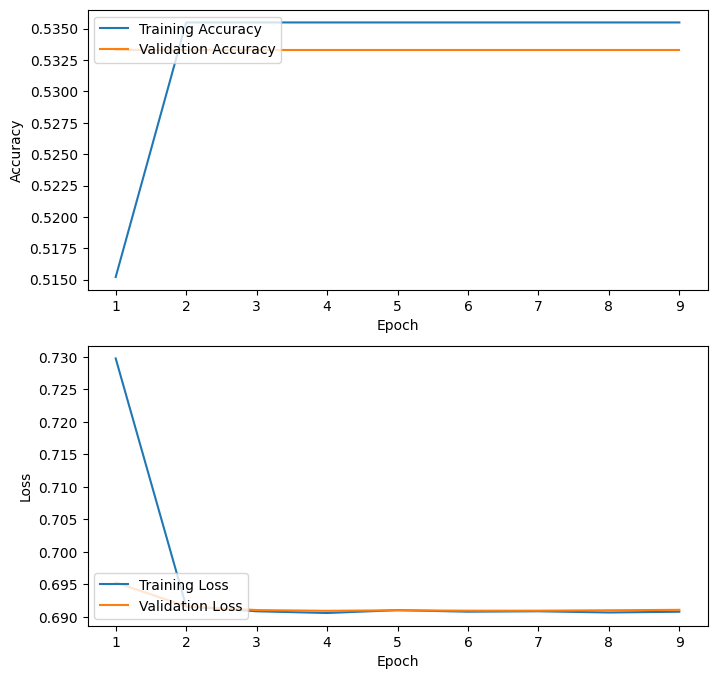

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from LeNet-5

After analyzing the accuracy and loss curves, it is evident that the current model lacks complexity. The accuracy curve shows that the model's accuracy does not exceed approximately 0.53, and remains level after epoch 2. This suggests that the architecture is not able to effectively learn from the dataset, resulting in underfitting. Both the train-accuracy and validation-accuracy curves show no significant progress. In terms of the loss curves, we observe that the model is converging to a local or global optimum very quickly, usually after epoch 2 or 3.

---

### 5.4.3.2 AlexNet

To explore a more complex model architecture, we will move beyond our initial baseline of LeNet-5 and investigate the capabilities of AlexNet. Introduced in 2012, AlexNet is a deeper architecture with significantly more trainable parameters (46.7 million compared to LeNet-5's 5.5 million), enabling it to potentially learn more complex features and patterns. Notably, AlexNet employs padding, the ReLu activation function, and built-in dropout layers for regularization, distinguishing it from LeNet-5.

Our goal is to assess whether AlexNet can effectively learn from our dataset, even if overfitting occurs initially. A better training score would indicate the model's ability to accurately identify the patterns and cracks present in our tire images. We expect the optimal solution to lie somewhere between LeNet-5 and AlexNet, requiring additional regularization techniques and fine-tuning to meet our specific use case requirements.

Again we will only use the non-augmented data.

*AlexNet Paper:* https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [ ]:
model_name = 'AlexNet'

In [ ]:
alexnet = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3. conv layer
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    # 4. conv layer
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    # 5. conv layer
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=4096, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=4096, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

alexnet.summary()

In [ ]:
# Compile Model
alexnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_alexnet = alexnet.fit(
    ds_train,
    validation_data = ds_val,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_alexnet, model_name=model_name)

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
5      6  0.677485      0.480952                 0.20
6      7  0.703854      0.523810                 0.18
7      8  0.673428      0.538095                 0.14
8      9  0.711968      0.419048                 0.29
9     10  0.691684      0.547619                 0.14

#### Takeaways from AlexNet

As expected AlexNet behaves opposite to the simple LeNet-5. With the given architecture we're clearly able to learn about normal or cracked tires. Besides that it's obvious that due to the complexity added the trained algorithm doesn't perform as well on the unseen validation data. This can be already observed between epoch 2-3 where the train-loss and validation-loss start to separate each other. A decreasing training-loss in combination with a leveling or increasing validation-loss is clear sign of overfitting. Of course this whole pattern could be better analyzed without early stopping.

We also recognize that this run stopped quite early due to early stopping with a patience of 5.

---

## 5.4.4 Handcrafted Model

To develop the *Handcrafted Model*, we will begin with the original AlexNet and aim to simplify its architecture while incorporating regularization techniques, in order to discover an appropriate solution. The reason for this approach is that getting more training data is not possible. That's why we have to downsize the model to degree where it only can store the as much information to detect the most important patterns and generalizes better.(See Chollet, 2018, p.104)[2]

### 5.4.4.1 HCM1

Our first custom-made model aimed to overcome the overfitting problem observed in the AlexNet model. To mitigate this issue, we augmented the training data by applying the following techniques: 

- **exposure.equalize_hist** custom function from scikit-image to enhance the contrast in the images. We hope this will lead to more detectable cracks 

- **image_brightness** ImageDataGenerator parameter to introduce more variability by adding a random brightness factor between the 0.5 & 1.5 to an image.

- **horizontal & vertical flip** ImageDataGenerator parameter for randomly flipping the images

These changes will be implemented to help the model generalize better and hopefully make the cracks more visible. Since adding more contrast to the training data has quite some impact we also applied the exposure.equalize_hist function on the validation and test set so they are still representative.

In [ ]:
model_name = 'Handcrafted1'

In [ ]:
hc1 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3. conv layer
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    # 4. conv layer
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    # 5. conv layer
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=4096, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=4096, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc1.summary()

In [ ]:
# Compile Model
hc1.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc1 = hc1.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc1, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
9      10  0.771873      0.642857                 0.13
10     11  0.778030      0.642857                 0.14
11     12  0.767660      0.652381                 0.12
12     13  0.777382      0.642857                 0.13
13     14  0.786779      0.652381                 0.13

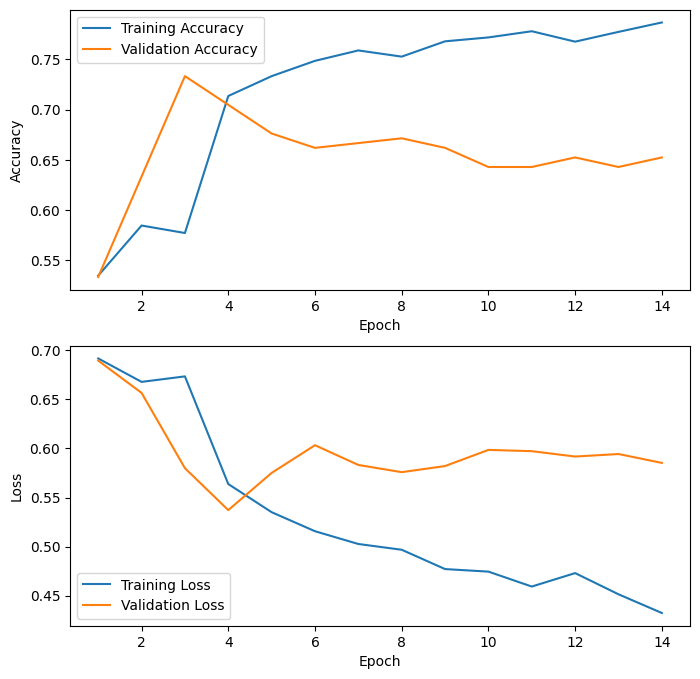

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from HCM1

Adding data augmentation, specifically exposure.equalize_hist, still leads to overfitting in the model. Despite this, the accuracy scores did change to some degree when compared to the AlexNet run. While not only the train-accuracy sligthly increased but also the validation-accuracy separates from the 0.5 level and levels off at around 0.65. Despite still overfitting, we plan to continue using the augmented dataset

---

### 5.4.4.2 HCM 2

The second model has a simpler architecture with fewer neurons in the dense layers. This can help lower the model's capacity and avoid overfitting. We will reduce the number of neurons by about roughly 50%, from 4096 to 2000 per layer. The expected result therefore is a better score on the validation set.


In [ ]:
model_name = 'Handcrafted2'

In [ ]:
hc2 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3. conv layer
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    # 4. conv layer
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    # 5. conv layer
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc2.summary()

In [ ]:
# Compile Model
hc2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc2 = hc2.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc2, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
10     11  0.770253      0.680952                 0.09
11     12  0.758263      0.676190                 0.08
12     13  0.780622      0.700000                 0.08
13     14  0.786455      0.695238                 0.09
14     15  0.785159      0.671429                 0.11

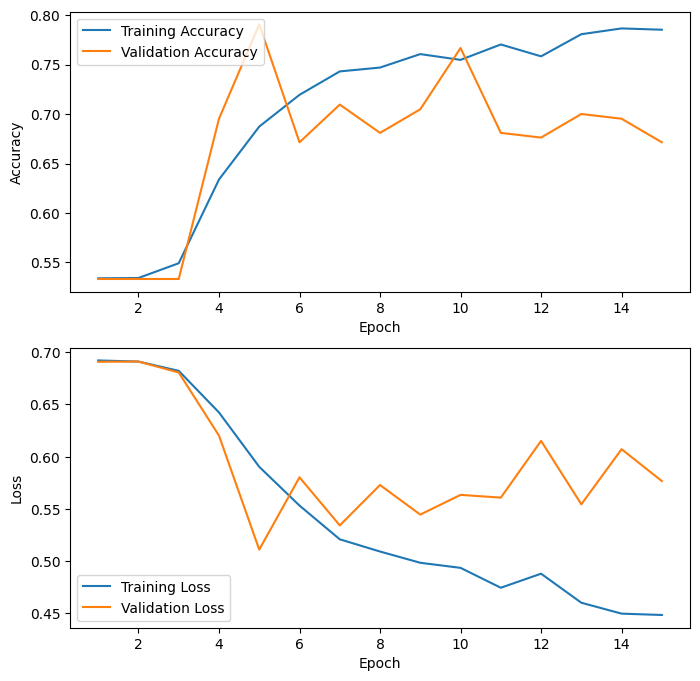

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from HCM2

Based on the given loss & accuracy curves it's possible to see the undertaken changes to the model indicated by a smoother start till around epoch 4. Also the expectations of a higher validation accuracy were fulfilled. Nevertheless the complexity reduction still isn't enough and should be further addressed.

### 5.4.4.3 HCM 3

For the third model, we continue to decrease complexity. This time, we make a more radical change and drop the last three convolutional layers. This will lead to a more shallow network with less filters/kernels. The motivation for this change is to reduce the risk of overfitting and to speed up the training process. We expect that this model will have lower accuracy than the previous ones.


In [ ]:
model_name = 'Handcrafted3'

In [ ]:
hc3 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc3.summary()

In [ ]:
# Compile Model
hc3.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc3 = hc3.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc3, model_name=model_name)

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
35     36  0.924174      0.809524                 0.11
36     37  0.921257      0.785714                 0.14
37     38  0.926442      0.776190                 0.15
38     39  0.921581      0.728571                 0.19
39     40  0.903759      0.690476                 0.21

#### Takeaways from HCM 4

Based on the loss and learning curves, it appears that the current model is still overfitting. The loss and accuracy metrics show kind of consistent behavior up until epoch 30, after which the validation accuracy starts to separate from the training accuracy. 

---

### 5.4.4.4 HCM 4

For the next deep learning model, it could be beneficial to try out kernel regularization and reducing the kernel size. Kernel regularization can help prevent overfitting by penalizing large weights in the network, which can lead to a more generalized model. However, it is important to carefully select the regularization strength as too much regularization can lead to underfitting. 

In [ ]:
model_name = 'Handcrafted4'

In [ ]:
hc4 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc4.summary()

In [ ]:
# Compile Model
hc4.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc4 = hc4.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc4, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
17     18  0.781270      0.752381                 0.03
18     19  0.780622      0.757143                 0.02
19     20  0.781270      0.757143                 0.02
20     21  0.787103      0.757143                 0.03
21     22  0.792288      0.752381                 0.04

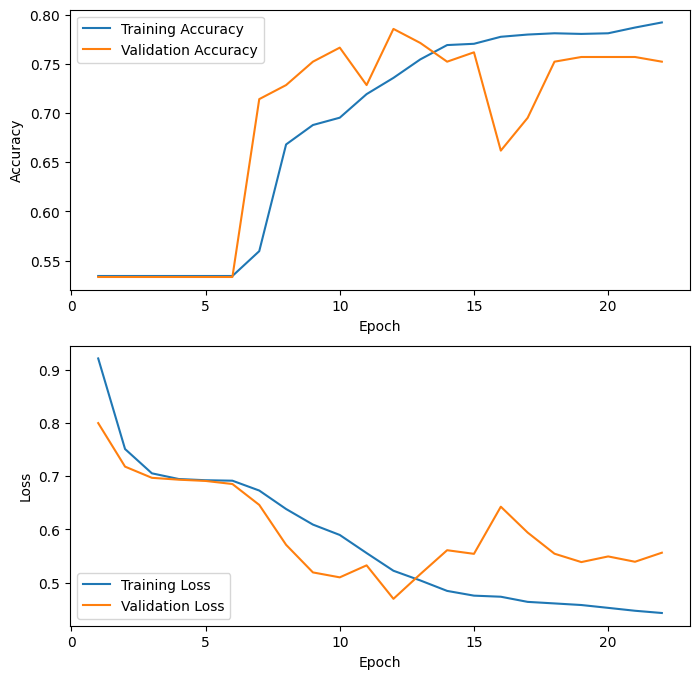

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways form HCM4

Based on the training metrics, it appears that your deep learning model experienced a plateau in accuracy between epoch 3 and epoch 6, but then experienced a significant drop in the loss curve and improved performance thereafter. This suggests that the model required some time to converge and learn the underlying patterns in the data. However, after epoch 13, the model shows signs of overfitting as the training accuracy continues to increase while the validation accuracy plateaus or decreases.

---

### 5.4.4.5 HCM 5

Based on the success of kernel regularization in the previous model, it may be worthwhile to experiment with increasing the regularization strength by doubling the values from 0.001 to 0.002 in the next model.

In [ ]:
model_name = 'Handcrafted5'

In [ ]:
hc5 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc5.summary()

In [ ]:
# Compile Model
hc5.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc5 = hc5.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc5, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
36     37  0.784511      0.747619                 0.04
37     38  0.785159      0.747619                 0.04
38     39  0.792288      0.742857                 0.05
39     40  0.793260      0.742857                 0.05
40     41  0.797796      0.742857                 0.05

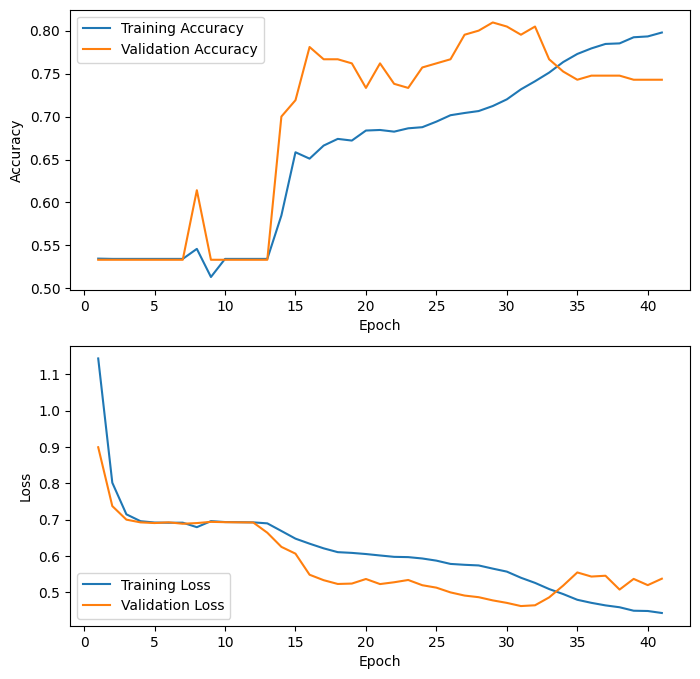

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from HCM5

Increasing the kernel regularization strength had a positive impact on the overfitting issue, but some overfitting still persisted after epoch 34. The loss curve remained relatively constant from epoch 3-13, indicating that the model again had difficulty learning the underlying patterns for some time.

---
### 5.4.4.6 HCM 6

Given the plateau's of the last two runs maybe BatchNormalization could be a solution. In theory it helps to prevent overfitting, speeds up training, and enables the use of higher learning rates. Therefore, it could bea smart addition to consider for the next model.

We therefore will apply a BatchNormalization layer after each convolutional layer.

*Paper:* https://arxiv.org/pdf/1502.03167.pdf

In [ ]:
model_name = 'Handcrafted6'

In [ ]:
hc6 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=2000, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc6.summary()

In [ ]:
# Compile Model
hc6.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc6 = hc6.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc6, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
17     18  0.993843      0.723810                 0.27
18     19  0.984770      0.761905                 0.22
19     20  0.981205      0.609524                 0.37
20     21  0.991251      0.695238                 0.30
21     22  0.996760      0.757143                 0.24

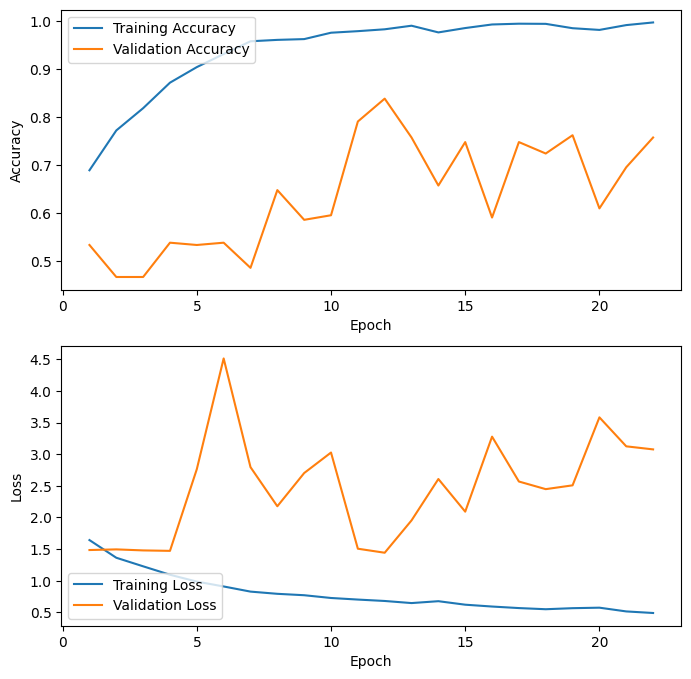

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from HCM6

It seems that the addition of BatchNormalization to the model may have led to overfitting from the beginning. While BatchNormalization is able to prevent overfitting in some cases, it is also known to increase the speed of convergence, which can lead to early overfitting if not properly controlled.

---

### 5.4.4.7 HCM 7

After overfitting again we will continue to reduce complexity. Also this time  we start by reducing neurons in the dense layers first. We will set them to be similar to the LeNet architecture, with 120 and 84 neurons, respectively.

In [ ]:
model_name = 'Handcrafted7'

In [ ]:
hc7 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=120, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=84, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc7.summary()

In [ ]:
# Compile Model
hc7.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc7 = hc7.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc7, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
15     16  0.974401      0.876190                 0.10
16     17  0.979261      0.809524                 0.17
17     18  0.971160      0.747619                 0.22
18     19  0.973104      0.823810                 0.15
19     20  0.977641      0.533333                 0.44

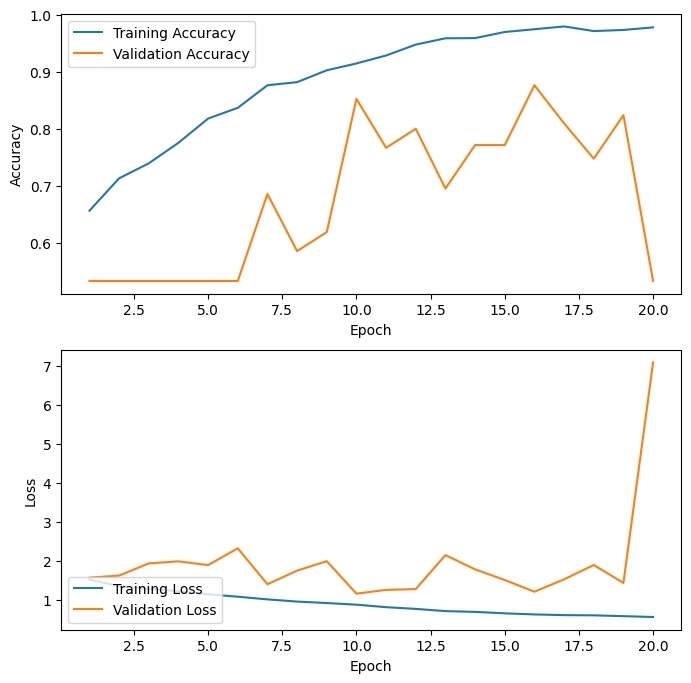

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from HCM7

Loss and accuracy curves are declining in a consistent manner, there is some evidence of slight overfitting. In particular, at epoch 18, the validation loss suddenly increases significantly, indicating that the model may have started to overfit to the training data.

---

### 5.4.4.8 HCM 8

Again reducing complexity by dropping the 3rd convolutional layer which makes the network less deep.

In [ ]:
model_name = 'Handcrafted8'

In [ ]:
hc8 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=96, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=120, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=84, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc8.summary()

In [ ]:
# Compile Model
hc8.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc8 = hc8.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc8, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
15     16  0.988982      0.847619                 0.14
16     17  0.995139      0.842857                 0.15
17     18  0.994167      0.814286                 0.18
18     19  0.995463      0.819048                 0.18
19     20  0.988658      0.747619                 0.24

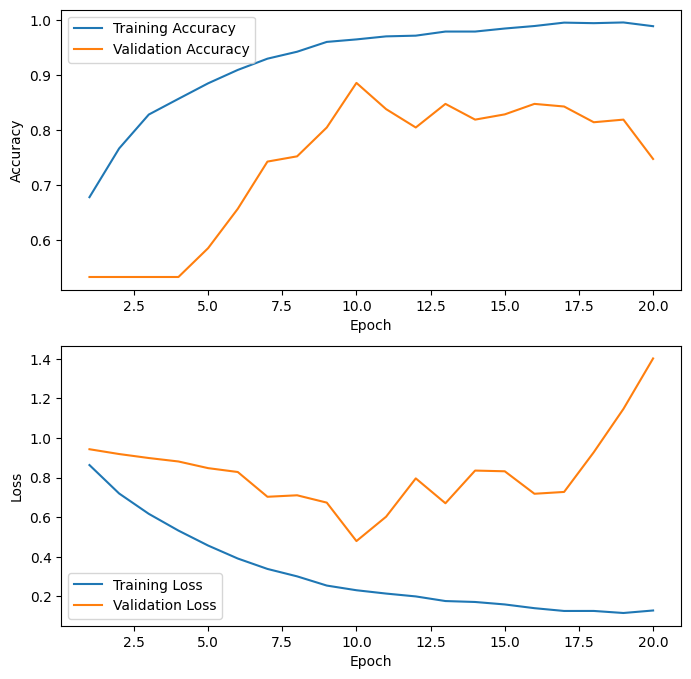

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from HCM8

Still overfitting

---

### 5.4.4.9 HCM 9

Downsizing the number of filters to the LeNet architecture to reduce even more complexity

1. Convolutional Layer 96  --> 6
2. Convolutional Layer 256 --> 16

In [ ]:
model_name = 'Handcrafted9'

In [ ]:
hc9 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=6, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=120, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=84, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc9.summary()

In [ ]:
# Compile Model
hc9.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc9 = hc9.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc9, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
13     14  0.868114      0.666667                 0.20
14     15  0.864874      0.723810                 0.14
15     16  0.873623      0.642857                 0.23
16     17  0.883992      0.666667                 0.22
17     18  0.884316      0.680952                 0.20

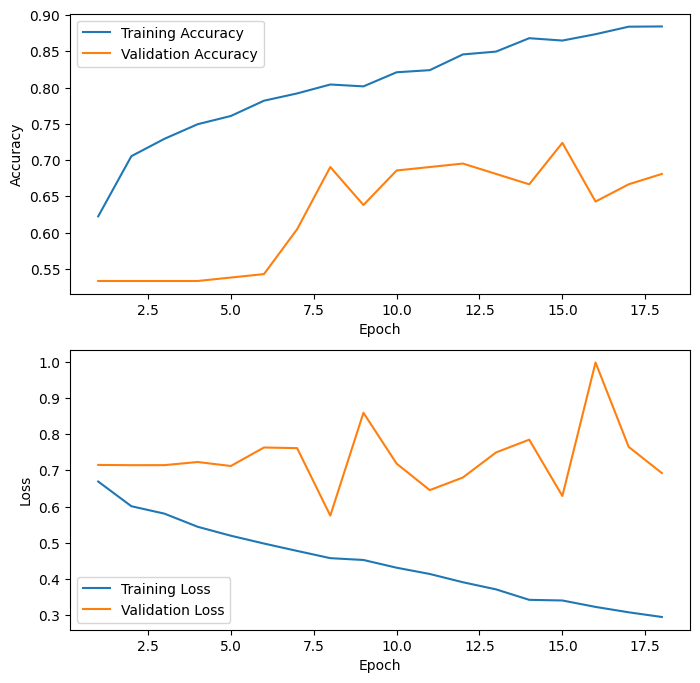

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from HCM9

Still overfitting

---

### 5.4.4.10 HCM 10

Downsizing the dense layers. Reducing the number of neurons by 50%.

1. Dense Layer 120 --> 60
2. Dense Layer 84 --> 42

In [ ]:
model_name = 'Handcrafted10'

In [ ]:
hc10 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=6, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=60, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=42, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc10.summary()

In [ ]:
# Compile Model
hc10.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc10 = hc10.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc10, model_name=model_name)

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
22     23  0.919961      0.766667                 0.15
23     24  0.914128      0.771429                 0.14
24     25  0.924822      0.757143                 0.17
25     26  0.918341      0.747619                 0.17
26     27  0.935839      0.771429                 0.16

#### Takeaways from HCM10

Still overfitting but based on the loss & accuracy curves it seems to get slighlty better.

---

### 5.4.4.11 HCM 11

Downsizing the dense layers. Again by reducing the number of neurons by 50%

1. Dense Layer 60 --> 30
2. Dense Layer 42 --> 21

In [ ]:
model_name = 'Handcrafted11'

In [ ]:
hc11 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=6, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=30, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=21, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc11.summary()

In [ ]:
# Compile Model
hc11.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc11 = hc11.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc11, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
31     32  0.854180      0.809524                 0.04
32     33  0.859689      0.761905                 0.10
33     34  0.866818      0.771429                 0.10
34     35  0.872975      0.466667                 0.41
35     36  0.879132      0.590476                 0.29

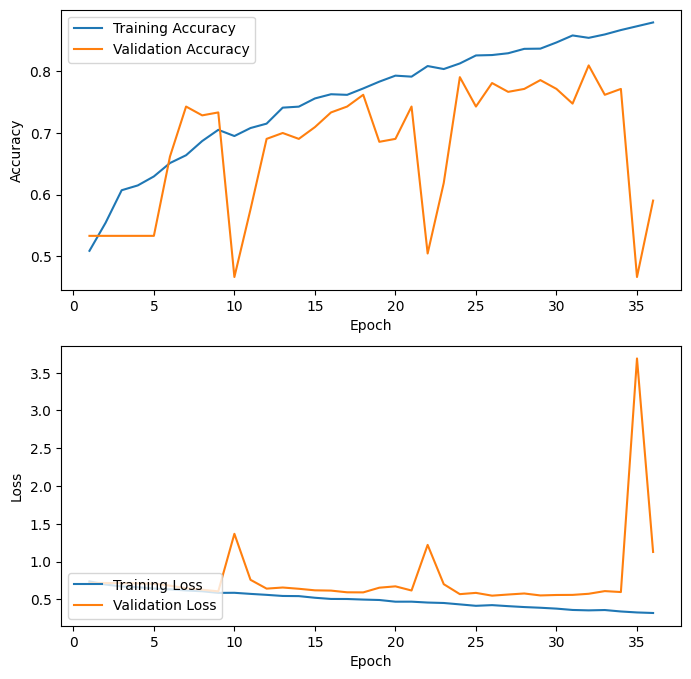

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

#### Takeaways from HCM11

Although the validation accuracy is quite volatile in this run, the loss curves getting better and better. The model seems to start overfitting at epoch 30.

---

### 5.4.4.12 HCM 12

Increase kernel regularization from 0.002 to 0.005.

In [ ]:
model_name = 'Handcrafted12'

In [ ]:
hc12 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=6, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=30, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=21, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc12.summary()

In [ ]:
# Compile Model
hc12.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc12 = hc12.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 50,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc12, model_name=model_name)

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
41     42  0.927414      0.823810                 0.10
42     43  0.931951      0.823810                 0.11
43     44  0.931951      0.819048                 0.11
44     45  0.931951      0.842857                 0.09
45     46  0.936163      0.842857                 0.09

#### Takeaway from HCM12

Still overfitting.

### 5.4.4.13 HCM 13

Again decreasing complexity. We will decrease the amount of filters in both of the convolutional layers as well as lowering the number of neurons.

1. Convolutional Layer 6 --> 5
2. Convolutional Layer 16 --> 5

1. Dense Layer 30 --> 10
2. Dense Layer 21 --> 5

In [ ]:
model_name = 'Handcrafted13'

In [ ]:
hc13 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=5, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=5, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=10, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=5, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc13.summary()

In [ ]:
# Compile Model
hc13.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc13 = hc13.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 100,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc13, model_name=model_name)

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
46     47  0.715813      0.661905                 0.05
47     48  0.730395      0.642857                 0.09
48     49  0.738496      0.661905                 0.08
49     50  0.736552      0.690476                 0.05
50     51  0.739145      0.623810                 0.12

#### Takeaways from HCM13

Still overfittin

---

### 5.4.4.14 HCM 14

Double the strength of the kernel regularization from 0.005 to 0.01.

In [ ]:
model_name = 'Handcrafted14'

In [ ]:
hc14 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=5, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=5, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=10, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=5, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc14.summary()

In [ ]:
# Compile Model
hc14.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc14 = hc14.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 100,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc14, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
95     96  0.779650      0.785714                -0.01
96     97  0.803629      0.761905                 0.04
97     98  0.790668      0.819048                -0.03
98     99  0.790019      0.771429                 0.02
99    100  0.793908      0.790476                 0.00

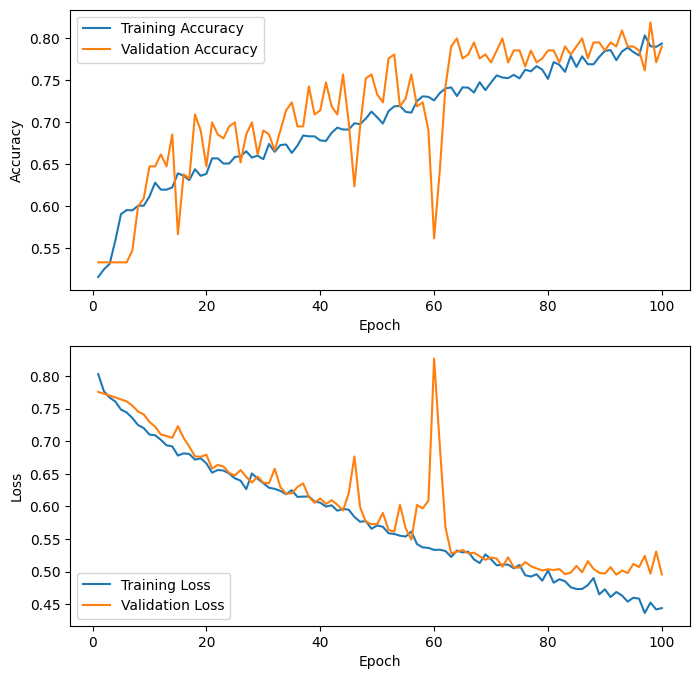

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

In [ ]:
# # Save this model as a checkpoint
# path = '/content/drive/MyDrive/DeepLearningProject/03 Project/Handcrafted_AlexNet/'
# hc14.save(path+'HandcraftedModel14.h5')

#### Takeaways from HCM14

It appears to be quite promising, as both the training and validation accuracy show a steady increase without any significant signs of overfitting. Looking at the last epoch results, the model achieved an accuracy of 79.39% on the training set and 79.05% on the validation set, with a difference of only 0.34%. This suggests that the model is performing well on both the training and validation sets, indicating good generalization.

Nevertheless after epoch 80 it seems to start overfitting.

---

### 5.4.4.15 HCM 15

We will still use the given architecture for our final moderl and try to increase the number of epochs.

In [ ]:
model_name = 'Handcrafted15'

In [ ]:
hc15 = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=5, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=5, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=10, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=5, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

hc15.summary()

In [ ]:
# Compile Model
hc15.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='auto'
    )

# Fit Model
cnn_hc15 = hc15.fit(
    ds_train_aug,
    validation_data = ds_val_aug,
    epochs = 200,
    callbacks=[early_stopping]
    )

plot_curves(model_fit=cnn_hc15, model_name=model_name)

Epoch  accuracy  val_accuracy  accuracy_difference
66     67  0.847375      0.819048                 0.03
67     68  0.850940      0.842857                 0.01
68     69  0.858393      0.833333                 0.03
69     70  0.856124      0.838095                 0.02
70     71  0.857097      0.847619                 0.01

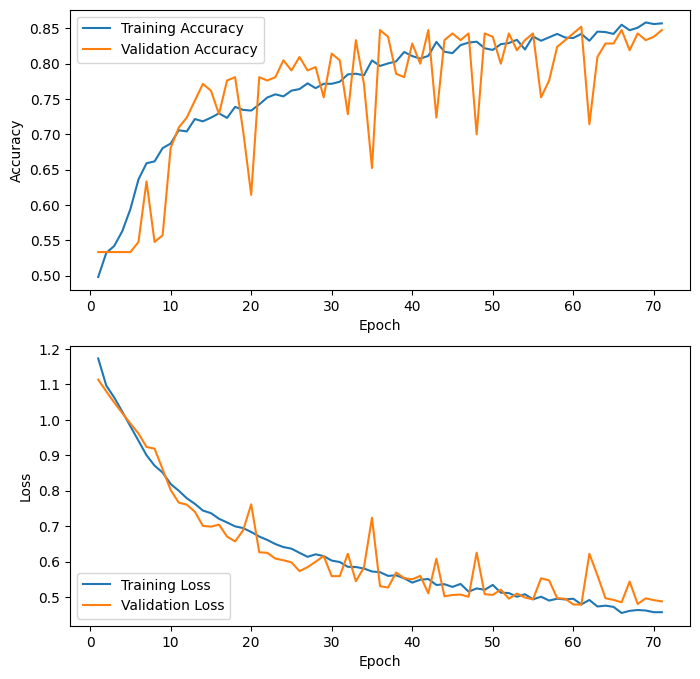

In [ ]:
#@title Saved Model Results
plot_curves(model_name=model_name)

In [ ]:
# # Save this model as a checkpoint
# path = '/content/drive/MyDrive/DeepLearningProject/03 Project/Handcrafted_AlexNet/'
# hc15.save(path+'HandcraftedModel15.h5')

#### Takeaways form HCM15

The final model again shows steadily increasing training and validation accuracy, and no signs of overfitting. However, the validation curves (loss & accuracy) appear to be quite volatile. This could be due to a number of factors, such as imbalanced class distributions in the validation set or noisy data. Despite this, the overall trend of increasing accuracy suggests that the model is learning and improving over time. Looking at the last epoch results, the model achieved an accuracy of 85.71% on the training set and 84.76% on the validation set, with a difference of only 0.95%.

## 5.4.5 Evaluating the model using the whole training data

In [ ]:
model_name = 'FinalModel'

In [ ]:
final = Sequential([
    # Input layer
    layers.Input(input_shape),
    # Rescale layer
    layers.Rescaling(1./255),
    # 1. conv layer
    layers.Conv2D(filters=5, kernel_size=(5,5), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2. conv layer
    layers.Conv2D(filters=5, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten
    layers.Flatten(),
    # 1. fully connected layer
    layers.Dense(units=10, activation='relu'),
    layers.Dropout(0.5),
    # 2. fully connected layer
    layers.Dense(units=5, activation='relu'),
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation="sigmoid")
    ], name=model_name)

final.summary()

Model: "FinalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 5)         380       
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 5)        20        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 5)         630       
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 5)        2

In [ ]:
# Compile Model
final.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Early Stopping
early_stopping_full = EarlyStopping(
    monitor='accuracy',
    patience=10,
    restore_best_weights=True)

# Fit Model
cnn_final = final.fit(
    ds_combined,
    epochs = 100,
    callbacks=[early_stopping_full]
    )

Epoch 1/100
75/75 [==============================] - 11s 21ms/step - loss: 1.1505 - accuracy: 0.4998
Epoch 2/100
75/75 [==============================] - 2s 20ms/step - loss: 1.0986 - accuracy: 0.5223
Epoch 3/100
75/75 [==============================] - 1s 16ms/step - loss: 1.0704 - accuracy: 0.5645
Epoch 4/100
75/75 [==============================] - 1s 16ms/step - loss: 1.0420 - accuracy: 0.5636
Epoch 5/100
75/75 [==============================] - 1s 16ms/step - loss: 1.0132 - accuracy: 0.5807
Epoch 6/100
75/75 [==============================] - 1s 16ms/step - loss: 0.9906 - accuracy: 0.6020
Epoch 7/100
75/75 [==============================] - 1s 16ms/step - loss: 0.9621 - accuracy: 0.6049
Epoch 8/100
75/75 [==============================] - 1s 16ms/step - loss: 0.9434 - accuracy: 0.6283
Epoch 9/100
75/75 [==============================] - 1s 16ms/step - loss: 0.9266 - accuracy: 0.6208
Epoch 10/100
75/75 [==============================] - 1s 18ms/step - loss: 0.9002 - accuracy: 0.639

In [ ]:
eval = final.evaluate(ds_test_aug)

/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


11/11 [==============================] - 115s 11s/step - loss: 0.7568 - accuracy: 0.5940


In [ ]:
print(f'Model Eval Test Data - Loss: {eval[0]}')
print(f'Model Eval Test Data - Score: {eval[1]}')

Model Eval Test Data - Loss: 0.7568192481994629
Model Eval Test Data - Score: 0.5940298438072205


## Conclusion

While the initial results of the final model seemed promising, it clearly visible that the model performed poorly on the test set, also when combining the train and test split.

There are several possible reasons for this, including the small size of the dataset, the volatility of the validation accuracy and loss, or the potential for overfitting on the validation set.

The size of the dataset is a critical factor that can impact the performance of deep learning models. When dealing with a small dataset, overfitting can often occur, where the model fits too closely to the training data and fails to generalize well to new, unseen data. This can cause the model to learn specific characteristics of the training data, rather than capturing the underlying patterns in the data as a whole.

Additionally, the volatility of the validation accuracy and loss can further increase this issue by indicating that the model is not stable and reliable.

To address these potential issues, future work could involve exploring ways to increase the size of the dataset, which could help the model better learn the underlying patterns in the data and generalize well to new, unseen data. 